In [2]:
import argparse
import cv2
import os
import logging
import uuid
import math
import numpy as np
import matplotlib.pyplot as plt

from utilities.focus.grayscaleImageFocus import *

In [4]:
def __seed_point_in_rectangle(seed_pt, rect):
    x,y,w,h = rect
    return (
        seed_pt[1] > x and 
        seed_pt[1] < x + w and
        seed_pt[0] > y and 
        seed_pt[0] < y + h
    )

def __rectangle_area(rect):
    return rect[2] * rect[3]

0.0
0.0
0.0
0.0
0.0
0.0


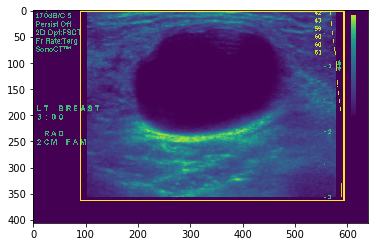

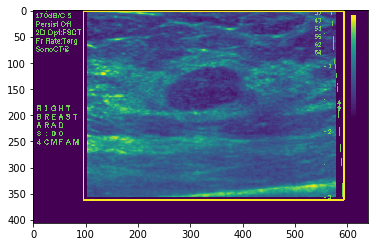

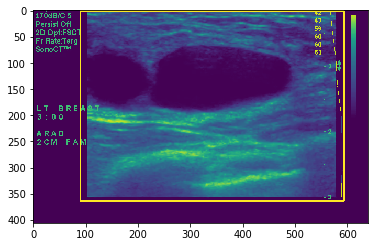

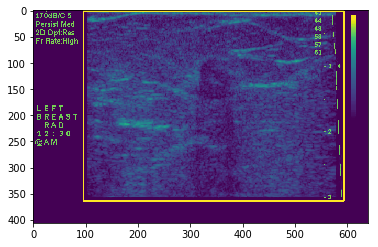

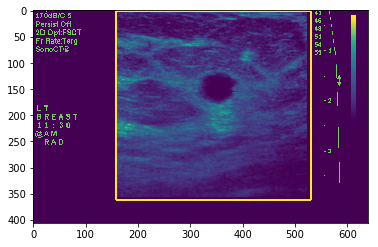

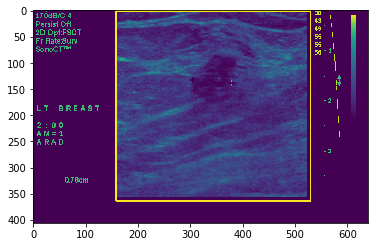

In [7]:
base_path = "../TestImages/frames"
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2, 2))

for impath in os.listdir(base_path):
    
    path_to_image = "{}/{}".format(base_path, impath)
    img = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    img = img[70:, :]
    
    
    lower_cutoff = np.mean(img[-10:, :10])
    print(lower_cutoff)
    
#     img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    otsu_thresh, img_morph = cv2.threshold(img, lower_cutoff,255, cv2.THRESH_BINARY)
    
    im2, contours, hierarchy = cv2.findContours(
        img_morph,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE)
    
    br = [cv2.boundingRect(c) for c in contours]
            
    # Map all rectangles to areas
    areas = [__rectangle_area(r) for r in br]
    
    # Select the smallest contour bounding the seed point as the ROI
    max_rect = br[np.argmax(areas)]

    x,y,w,h = max_rect
    
    cv2.rectangle(
        img,
        (x,y),
        (x+w, y+h),
        255,
        2)
    
    plt.figure()
    plt.imshow(img)
    
#     break


In [6]:
def get_grayscale_image_focus(
    path_to_image, 
    path_to_output_directory, 
    HSV_lower_bound, 
    HSV_upper_bound,
    interpolation_factor=None,
    interpolation_method=cv2.INTER_CUBIC):
    """
    Determines the "focus" of an ultrasound frame in Color/CPA. 

    Ultrasound frames in Color/CPA mode highlight the tumor under examination to 
    focus the direction of the scan. This function extracts the highlighted region, which
    is surrounded by a bright rectangle and saves it to file. 

    Arguments:
        path_to_image: path to input image file
        path_to_output_directory: path to output directory 
        HSV_lower_bound: np.array([1, 3], uint8) lower HSV threshold to find highlight box
        HSV_upper_bound: np.array([1, 3], uint8) upper HSV threshold to find highlight box

    Returns:
        path_to_image_focus: path to saved image focus with has as filename

    Raises:
        IOError: in case of any errors with OpenCV or file operations 

    """
    try:
        
        # Load the image and convert it to HSV from BGR
        # Then, threshold the HSV image to get only target border color
        bgr_image = cv2.imread(path_to_image, cv2.IMREAD_COLOR)
        bgr_image = bgr_image[70:, 90:]
        mask = cv2.inRange(
            bgr_image, 
            HSV_lower_bound, 
            HSV_upper_bound)

        # Determine contours of the masked image

        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]

        if len(contours) == 0:
             raise Exception("Unable to find any matching contours")

        # Contour with maximum enclosed area corresponds to highlight rectangle
        
        max_contour = max(contours, key = cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Crop the image to the bounding rectangle

        focus_image = bgr_image[y:y+h, x:x+w]

  
        # The bounding box includes the border. Remove the border by masking on the same 
        # thresholds as the initial mask, then flip the mask and draw a bounding box. 

        focus_hsv = cv2.cvtColor(focus_image, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(
            focus_hsv, 
            HSV_lower_bound, 
            HSV_upper_bound)
            
        mask = cv2.bitwise_not(mask)

        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]

        if len(contours) == 0:
            raise Exception("Unable to find any matching contours")

        #find the biggest area
        max_contour = max(contours, key = cv2.contourArea)

        x, y, w, h = cv2.boundingRect(max_contour)

        # Crop the image to the bounding rectangle
        # As conservative measure crop inwards 3 pixels to guarantee no boundary

        cropped_image = focus_image[y+3:y+h-3, x+3:x+w-3]

        # Interpolate (upscale/downscale) the found segment if an interpolation factor is passed
        if interpolation_factor is not None:
            cropped_image = cv2.resize(
                cropped_image, 
                None, 
                fx=interpolation_factor, 
                fy=interpolation_factor, 
                interpolation=interpolation_method)

        output_path = "{0}/{1}.png".format(path_to_output_directory, uuid.uuid4())

        cv2.imwrite(output_path, cropped_image)

        return output_path

    except Exception as exception:
        raise IOError("Error isolating and saving image focus")
